# ACA centroiding/ Dynamic Background/ Simulations#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime
from copy import deepcopy
from importlib import reload

In [2]:
# local imports:
import sys
sys.path.append("../py")
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Contents ###

1. Simulate telemetry in <code>aca_l0</code> format.
2. Construct background images using various algorithms.
3. Centroids.
4. Plotting functions.
5. Examples:
    * Simulated case with constant background, no hot pixels.
    * Simulated case with 1 hot pixel.
    * Real data (HRC, large dither amplitude of 20 arcsec).

### 1. Simulate telemetry in <code>aca_l0</code> format ###

Relevant functions are imported from <code>py/sim_aca_l0.py</code> as <code>siml0</code>.


Star is modeled as a 2D Gaussian plus constant background. It is simulated at the center of a ACA image window <code>(0 + roff, 0 + coff)</code> where the sub-pixel offsets in both row and column (<code>roff, coff</code>) are due to simulated dither (check <code>validation.ipynb</code> for details of the simulated dither).


Hot pixels are added as a dictionary <code>hot_pixels</code> with keys refering to the absolute CCD coordinates, e.g. <code>(6, 6)</code>.

### 2. Construct background images using various algorithms###

* __Patch D/ Dynamic List - Focus of this notebook.__ Detect hot pixels on-the-fly while tracking. Use n latest pixel samples.


* Relevant code is imported from <code>py/bgd_classes.py</code>.


* Implemented background classes include:

    * Current algorithm, assign average background value telemetered in <code>aca_l0</code> to each pixel, independently of its real value.
        
        * __StandardBgd__
        
    * Store real values of the sampled edge pixels, and telemetered average background value for the remaining pixels.
    
        * __DynamBgd_Median__. Median of n samples.
    
        * __DynamBgd_SigmaClip__. Sigma clipping, i.e. mean of <code>(n-2)</code> samples, after discarding max and min.

### 3. Centroids ###

Relevant functions are imported from <code>py/centroids.py</code> as <code>cntr</code>.

### 4. Plotting functions ###

Relevant functions are imported from <code>py/myplot.py</code> as <code>mplt</code>.

### 5. Examples###

Simulate a faint 10.2 mag and a bright 8.2 mag star, with
* constant background, and 1 static hot pixel (with a set value + shot noise).
* constant background, and 1 flickering hot pixel.
* compare cases with small (5) and large (1000) number of bgd pixel samples.

In [3]:
def do_computations(slot, img_size, hot_pixels=None, init_kwargs=None, \
                    nframes=1000, ndeque=1000, delta_t=4.1, integ=1.696, \
                    bgdavg=None, fwhm=1.8, mag=10.2, \
                    delta=-0.25,  ampl=8., period=1000., phase=0.):
    
    rows_all = []

    for mag in mags:
    
        kwargs['mag'] = mag
    
        np.random.seed(42)
        slot_data, true_centroids = siml0.simulate_aca_l0(img_size, hot_pixels=hot_pixels, **kwargs)
    
        for i, Bgd_Class in enumerate([StandardBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**init_kwargs[i]) 
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = mag
                row['bgd_type'] = bgd_object.__class__.__name__
                row['true_row'] = true_centroids[0]
                row['true_col'] = true_centroids[1]
                y_pixels = true_centroids[0] + row['row0']
                z_pixels = true_centroids[1] + row['col0']
                true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)
                row['true_yan'] = true_yanzan[0]
                row['true_zan'] = true_yanzan[1]
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = init_kwargs[i]['ndeque']
                else:
                    row['ndeque'] = None

                rows_all.append(row)
        
    t = Table(rows_all)
    return t

In [4]:
img_size = 8 # pixels
delta_t = 4.1 # sec
integ = 1.696 # sec
nframes = 1000

In [5]:
# Define dither parameters
ampl, period = siml0.dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [6]:
# Average background
bgdavg = 10. # pixel value

### Example: Simulation - 1 hot pixel with constant value###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one persistent hot pixel__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 

__Small__ number of samples

In [7]:
ndeque = 5 # number of vals in deque before we start to popleft()

In [8]:
# Kwargs for simulated aca_l0 data
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
          'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}

# Example 2: for hot pixel sampled only after the first t = 500sec use
# kwargs['phase'] = 0.

Define hot pixel(s):

In [9]:
# Test with only one hot pixel
np.random.seed(42)
hp = StaticHotPixel(val=500, sigma=25, size=nframes)
hot_pixels = {(6, 6):hp.hp}

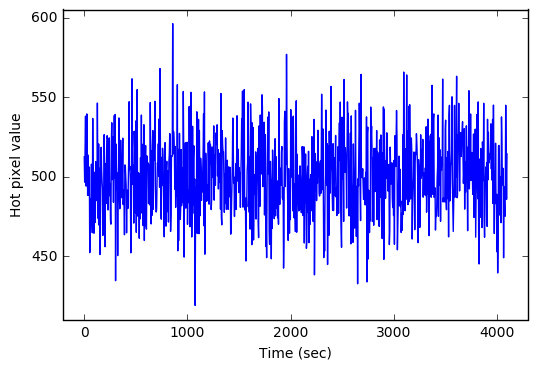

In [10]:
plt.plot(np.arange(nframes) * delta_t, hp.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.margins(0.05)

In [11]:
slot = 0
mags = [10.2, 8.2] # mag

# Keywords to initialize a background object bgd_object
init_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                   {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

In [12]:
t_hp_5 = do_computations(slot, img_size, hot_pixels=hot_pixels, init_kwargs=init_kwargs, **kwargs)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


In [13]:
print(t_hp_5.colnames)

['bgd_type', 'bgdimg', 'col', 'col0', 'deque_dict', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']


In [14]:
print(t_hp_5['bgd_type', 'mag', 'ndeque'])

     bgd_type      mag  ndeque
------------------ ---- ------
       StandardBgd 10.2   None
   DynamBgd_Median 10.2      5
DynamBgd_SigmaClip 10.2      5
       StandardBgd  8.2   None
   DynamBgd_Median  8.2      5
DynamBgd_SigmaClip  8.2      5


__Plot derived bgd images__

* <span style="color:darkblue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:dodgerblue">8x8 patch</span> - 8x8 pixel region corresponding to the current frame
* Notice <span style="color:maroon">hot pixel</span> in the upper right corner

In [15]:
reload(mplt)

<module 'myplot' from '../py/myplot.py'>

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgd images from 0 to 10
Method: DynamBgd_Median, ndeque = 5


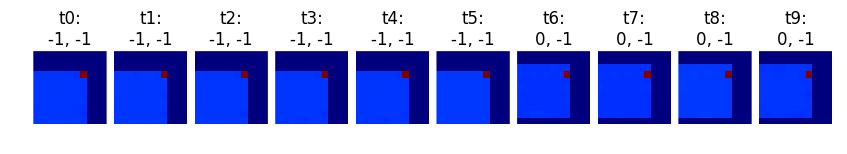

In [16]:
# Faint star
mplt.plot_bgd_images(t_hp_5, slot=0, mag=mags[0], n_start=0, n_stop=10,
                     img_size=img_size, method='DynamBgd_Median')

* <span style="color:darkblue">Blue patch</span> - region eventually covered due to the dither
* <span style="color:dodgerblue">Light blue</span> - region sampled at time t (the sampled region increases with t)
* Notice <span style="color:maroon">hot pixel</span> in the upper right corner

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 10
Method: DynamBgd_Median, ndeque = 5


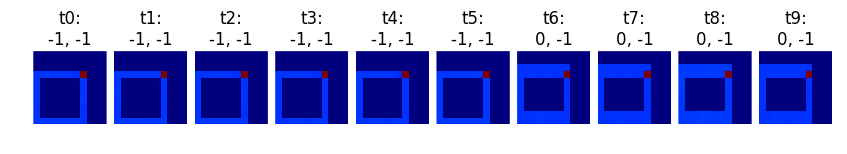

In [17]:
# Faint star
mplt.plot_bgd_patches(t_hp_5, slot=0, mag=mags[0], n_start=0, n_stop=10, img_size=img_size,
                      method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 300 to 310
Method: DynamBgd_Median, ndeque = 5


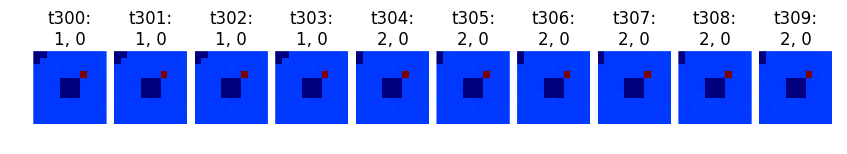

In [18]:
mplt.plot_bgd_patches(t_hp_5, slot=0, mag=mags[0], n_start=300, n_stop=310, img_size=img_size,
                      method='DynamBgd_Median')

__Plot the computed and 'true' centroids (row number and yan coordinates)__

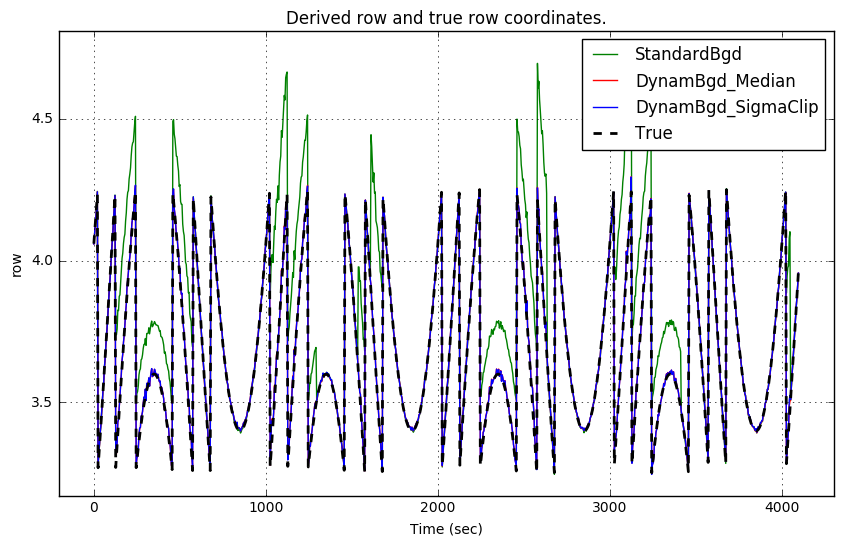

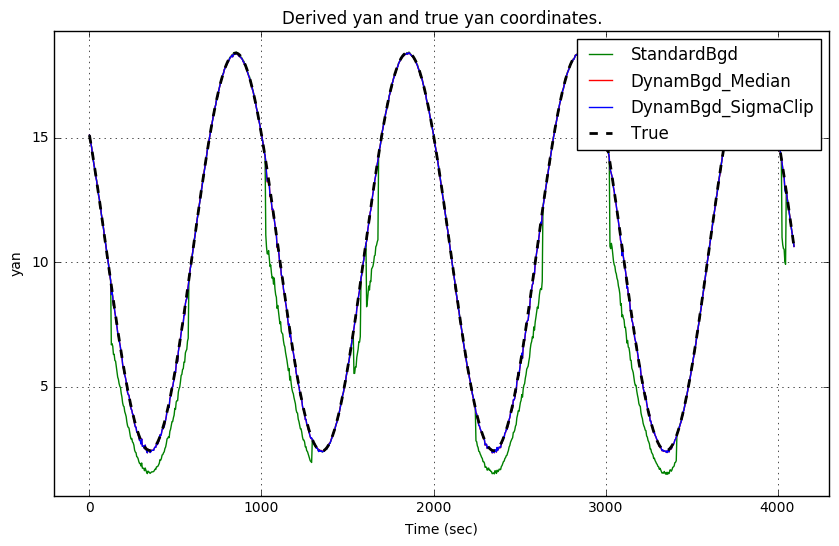

In [19]:
mplt.plot_coords(slot, t_hp_5, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_hp_5, 'yan') # computed 'yan' coordinate

__Plot the difference between the computed and 'true' coordinates__

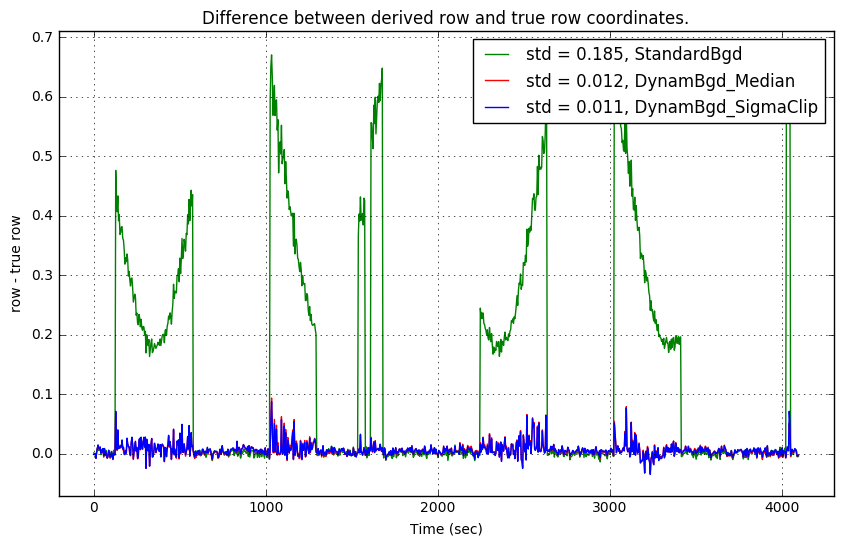

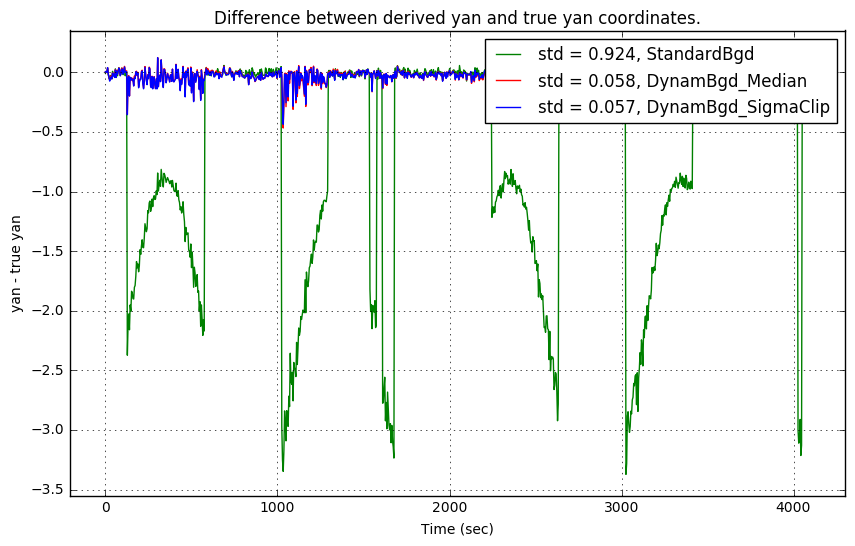

In [20]:
mplt.plot_coords_excess(slot, t_hp_5, 'row')
mplt.plot_coords_excess(slot, t_hp_5, 'yan')

__Plot residuals__

In [21]:
def plot_resids(table):
    faint = table['mag'] == 10.2
    bright = table['mag'] == 8.2

    key = 'yan'

    fig = plt.figure(figsize=(10, 2.5))

    ylim = (-0.5, 2.5)

    methods = ['StandardBgd', 'DynamBgd_Median', 'DynamBgd_SigmaClip']

    for i, method in enumerate(methods):
        plt.subplot(1, 3, i + 1)
        d_ang = table[bright][key][i] - table[faint][key][i]
        plt.plot(table['time'][0], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.title(method)    
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.legend()
        plt.ylim(ylim)
        plt.margins(0.05)
    
    plt.subplots_adjust(wspace=0.3)
    print("Bright - Faint star, ndeque = {}".format(table[1]['ndeque']))

Bright - Faint star, ndeque = 5


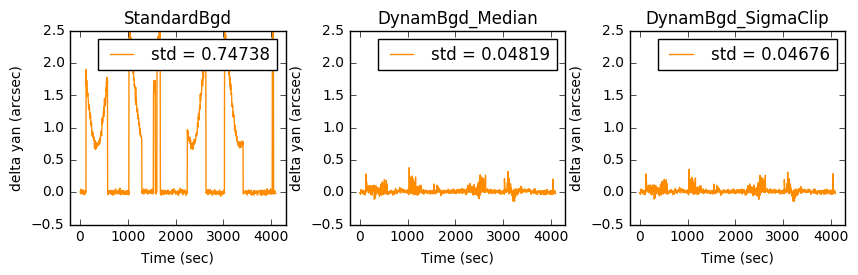

In [22]:
plot_resids(t_hp_5)

__Large__ number of samples

In [23]:
ndeque = 1000 # number of vals in deque before we start to popleft()
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [24]:
t_hp_1000 = do_computations(slot, img_size, hot_pixels=hot_pixels, init_kwargs=init_kwargs, **kwargs)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


Bright - Faint star, ndeque = 1000


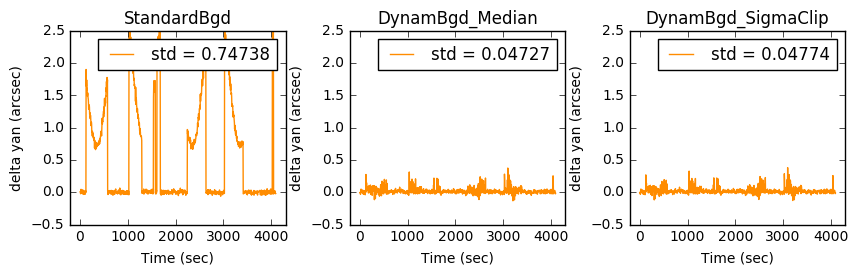

In [25]:
plot_resids(t_hp_1000)

### Example: Simulation - 1 hot pixel with flickering value###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __one hot flickering pixel__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code> 

In [26]:
np.random.seed(42)
fhp = FlickeringHotPixel(vals=[400, 200], sigmas=[1, 1], locs=[250, 500, 750], size=nframes)

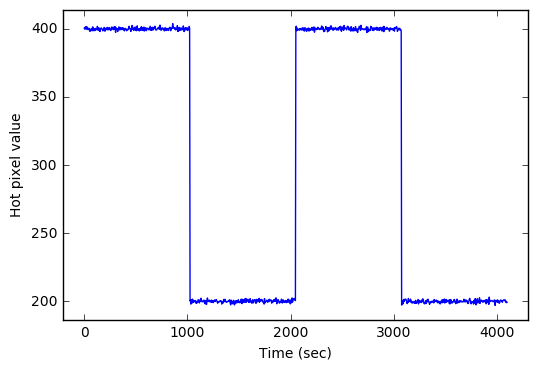

In [27]:
plt.plot(np.arange(nframes) * delta_t, fhp.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.margins(0.05)

hot_pixels = {(6, 6):fhp.hp}

__Small__ number of samples

In [28]:
ndeque = 5 # number of vals in deque before we start to popleft()
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [29]:
t_fhp_5 = do_computations(slot, img_size, hot_pixels=hot_pixels, init_kwargs=init_kwargs, **kwargs)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


Bright - Faint star, ndeque = 5


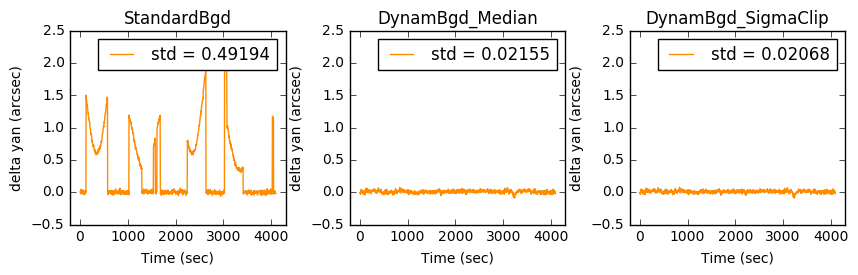

In [30]:
plot_resids(t_fhp_5)

__Large__ number of samples

In [31]:
ndeque = 1000 # number of vals in deque before we start to popleft()
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [32]:
t_fhp_1000 = do_computations(slot, img_size, hot_pixels=hot_pixels, init_kwargs=init_kwargs, **kwargs)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


In [44]:
ok1 = t_fhp_1000['bgd_type'] == 'DynamBgd_Median'
ok2 = t_fhp_1000['slot'] == 0
ok3 = t_fhp_1000['mag'] == mags[0]
ok = ok1 * ok2 * ok3

lens = []
for key, val in t_fhp_1000[ok]['deque_dict'][0][-1].items():
    lens.append(len(val))
    
print("Min deque length = {}, Max deque length = {}".format(np.min(lens), np.max(lens)))

Min deque length = 51, Max deque length = 563


Bright - Faint star, ndeque = 1000


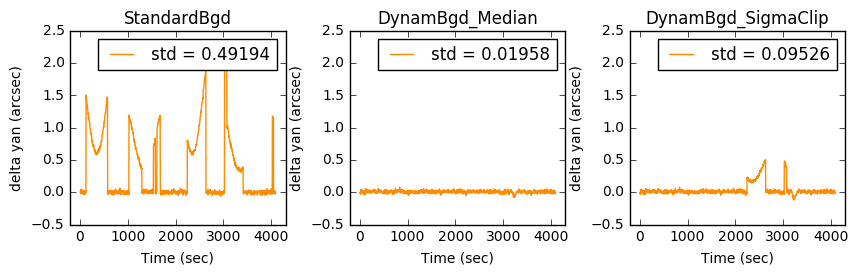

In [33]:
plot_resids(t_fhp_1000)

__Result:__ <code>DynamBgd_SigmaClip</code> may underestimate hot pixel subtraction.

* At times 0-1000 sec the hot pixel is sampled at high value and the images are corrected.
* At times 1000-2000 sec the hot pixel is sampled at its low value and the images are corrected as well (why there is no signature of oversubtracting?
* At times 2000-3000 sec the hot pixel is sampled at its high value but the mean used in SigmaClip is affected by the prior low values and the hot pixel is underestimated.

__Add more noise to the flickering hot pixel__

In [34]:
np.random.seed(42)
fhp = FlickeringHotPixel(vals=[400, 200], sigmas=[25, 25], locs=[250, 500, 750], size=nframes)

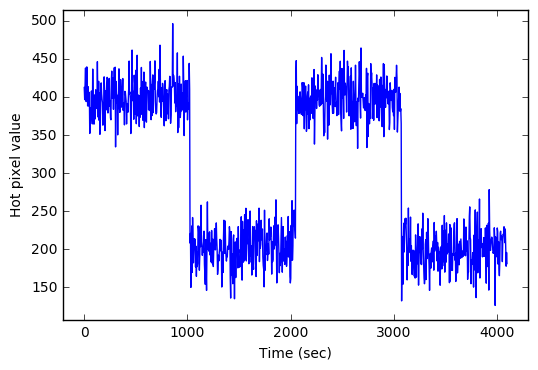

In [35]:
plt.plot(np.arange(nframes) * delta_t, fhp.hp)
plt.xlabel("Time (sec)")
plt.ylabel("Hot pixel value")
plt.margins(0.05)

hot_pixels = {(6, 6):fhp.hp}

__Small__ number of samples

In [36]:
ndeque = 5 # number of vals in deque before we start to popleft()
init_kwargs[1]['ndeque'] = ndeque
init_kwargs[2]['ndeque'] = ndeque

In [37]:
t_fhp_noise_5 = do_computations(slot, img_size, hot_pixels=hot_pixels, init_kwargs=init_kwargs, **kwargs)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


Bright - Faint star, ndeque = 5


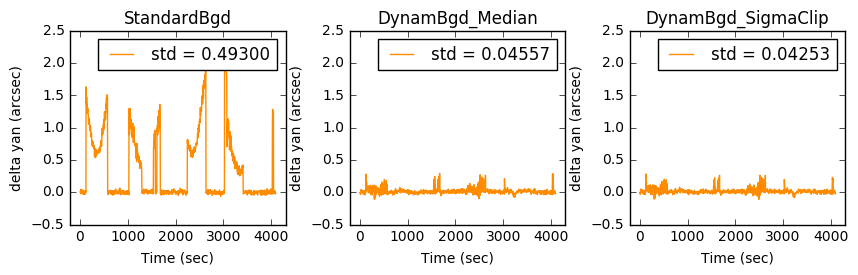

In [38]:
plot_resids(t_fhp_noise_5)

__Results:__ Compare cell 22 (static hot pixel with noise) and 38 (flickering hot pixel with noise), ndeque=5. Performance of Median and SigmaClip is comparable.